In [1]:
import numpy
import py_entropy
from matplotlib import pyplot
import os

from tqdm.notebook import tqdm

pyplot.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [2]:
output_dir = "dephased_states"

os.makedirs(output_dir, exist_ok=True)

# Uniformly Delocalized and Mixed

In [3]:
def dephase_site(site, probs_and_states):
    all_ps_ss = []
    for p,s in probs_and_states:
        (pa,sa), (pb,sb) = s.trace_out_site(site)
        if pa > 0.0:
            all_ps_ss.append((p*pa, sa))
        if pb > 0.0:
            all_ps_ss.append((p*pb, sb))
    return all_ps_ss

def dephase_sites(start,end,probs_and_states):
    for i in range(start, end):
        probs_and_states = dephase_site(i, probs_and_states)
    return probs_and_states

In [4]:
n = 16
ne = 1000
k = 1000

filename = os.path.join(output_dir, f"dephased_uniform_l={n}.npz")

input_states = []
for i in range(n):
    for j in range(i+1,n):
        input_states.append([i,j])
input_states = numpy.array(input_states).astype(numpy.uint64)
D = len(input_states)
amplitudes = numpy.ones((len(input_states)), dtype=numpy.complex128) / numpy.sqrt(D)
ps = py_entropy.MultidefectPureState(input_states, amplitudes)

print(filename)
print(os.path.exists(filename))

if os.path.exists(filename):
    arr = numpy.load(filename)
    all_purities = arr['data']
    D = arr['D']
else:
    all_purities = []

    for i in tqdm(range(0,n+1)):
        probs_and_states = dephase_sites(0,i,[(1.0, ps)])

        s = py_entropy.MultiDefectState.new_mixed_from_states(probs_and_states,
                                        n,
                                        num_experiments=ne, 
                                        skip_float_checks=True)
        initial_purity = s.get_mean_purity()
        purities = s.apply_alternative_layers_and_save_mean_purity(k)
        purities = numpy.hstack([numpy.expand_dims(initial_purity, axis=0), purities])
        all_purities.append(purities)
    all_purities = numpy.array(all_purities)
    numpy.savez(filename, data=all_purities, D=D)

dephased_states/dephased_uniform_l=16.npz
True


In [5]:
true_purities = []
for i in range(0,n+1):
    probs_and_states = dephase_sites(0,i,[(1.0, ps)])
    true_purities.append(sum(p**2 for p, _ in probs_and_states))
true_purities

[1.0,
 0.78125,
 0.602361111111111,
 0.4579166666666667,
 0.3429166666666667,
 0.2527777777777778,
 0.18333333333333335,
 0.13083333333333336,
 0.09194444444444445,
 0.06375000000000001,
 0.04375000000000001,
 0.029861111111111116,
 0.020416666666666677,
 0.014166666666666682,
 0.010277777777777792,
 0.008333333333333347,
 0.008333333333333352]

In [6]:
theory_purities = []
for i in range(0,n+1):
    numerator = 4 * (n - i)**2 * i + 2 * (i - 1)*i + (n-i)**2 * (1-n+i)**2
    denom = (n - 1)**2 * n**2
    theory_purities.append(numerator/denom)
theory_purities

[1.0,
 0.78125,
 0.6023611111111111,
 0.4579166666666667,
 0.34291666666666665,
 0.25277777777777777,
 0.18333333333333332,
 0.13083333333333333,
 0.09194444444444444,
 0.06375,
 0.04375,
 0.029861111111111113,
 0.020416666666666666,
 0.014166666666666666,
 0.010277777777777778,
 0.008333333333333333,
 0.008333333333333333]

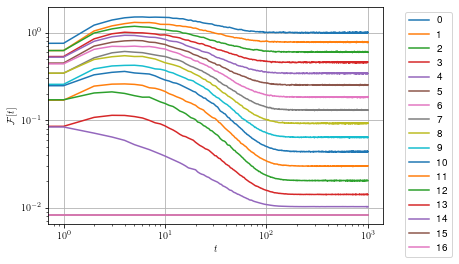

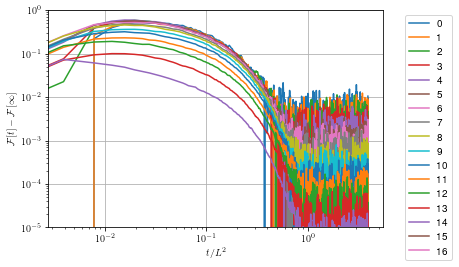

In [7]:
for i,purs in enumerate(all_purities):
    pyplot.plot(purs, label=f'{i}')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylabel('$\mathcal{F}[t]$')
pyplot.xlabel('$t$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

for i,purs in enumerate(all_purities):
    pyplot.plot(numpy.arange(len(purs))/n**2, purs - true_purities[i], label=f'{i}')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,1e0])
pyplot.ylabel('$\mathcal{F}[t] - \mathcal{F}[\infty]$')
pyplot.xlabel('$t/L^2$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

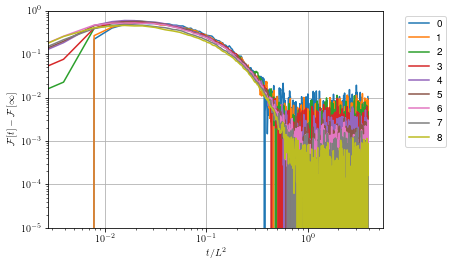

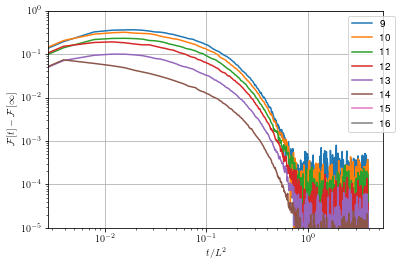

In [8]:
for i in range(0,len(all_purities)//2+1):
    purs = all_purities[i]
    pyplot.plot(numpy.arange(len(purs))/n**2, purs - true_purities[i], label=f'{i}')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,1e0])
pyplot.ylabel('$\mathcal{F}[t] - \mathcal{F}[\infty]$')
pyplot.xlabel('$t/L^2$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

for i in range(len(all_purities)//2+1,len(all_purities)):
    purs = all_purities[i]
    pyplot.plot(numpy.arange(len(purs))/n**2, purs - true_purities[i], label=f'{i}')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,1e0])
pyplot.ylabel('$\mathcal{F}[t] - \mathcal{F}[\infty]$')
pyplot.xlabel('$t/L^2$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

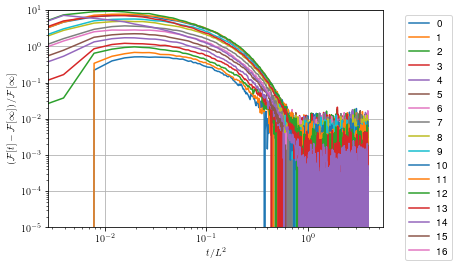

In [9]:
for i,purs in enumerate(all_purities):
    pyplot.plot(numpy.arange(len(purs))/n**2, (purs - true_purities[i])/true_purities[i], label=f'{i}')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,1e1])
pyplot.ylabel(r'$\left(\mathcal{F}[t] - \mathcal{F}[\infty]\right)/\mathcal{F}[\infty]$')
pyplot.xlabel('$t/L^2$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

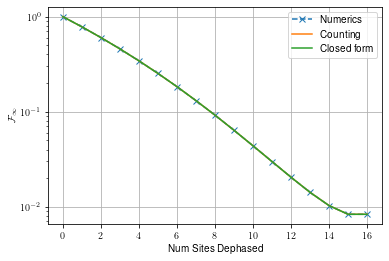

In [10]:
pyplot.plot(all_purities[:,-100:].mean(axis=-1), 'x--', label="Numerics")
pyplot.yscale('log')
pyplot.grid()

pyplot.plot(true_purities, label="Counting")
pyplot.yscale('log')
pyplot.grid()

pyplot.plot(theory_purities, label="Closed form")
pyplot.yscale('log')
pyplot.grid()

pyplot.legend()
pyplot.ylabel(r"$\mathcal{F}_\infty$")
pyplot.xlabel("Num Sites Dephased")
pyplot.show()

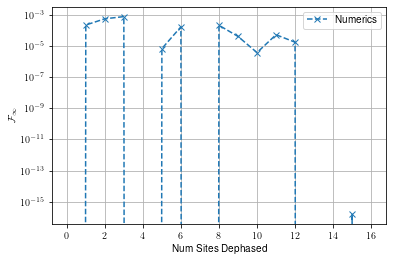

In [11]:
pyplot.plot(all_purities[:,-100:].mean(axis=-1) - theory_purities, 'x--', label="Numerics")
pyplot.yscale('log')
pyplot.grid()

pyplot.legend()
pyplot.ylabel(r"$\mathcal{F}_\infty$")
pyplot.xlabel("Num Sites Dephased")
pyplot.show()

# Compare halves?

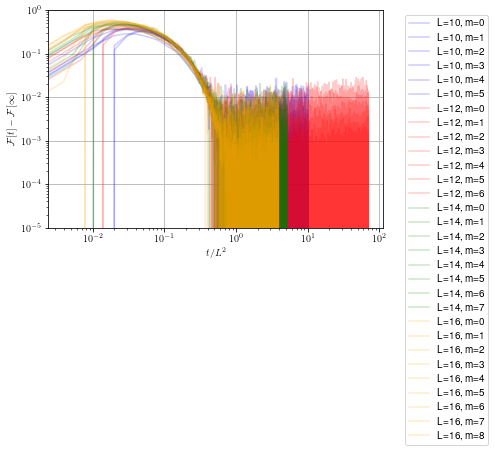

In [16]:
ns = [10,12,14,16]

colors = {
    n: c for n,c in zip(ns, ["b", "r", "g", "orange"])
}

for n in ns:
    filename = os.path.join(output_dir, f"dephased_uniform_l={n}.npz")

    arr = numpy.load(filename)
    all_purities = arr['data']
    D = arr['D']
    
    theory_purities = []
    for i in range(0,n+1):
        numerator = 4 * (n - i)**2 * i + 2 * (i - 1)*i + (n-i)**2 * (1-n+i)**2
        denom = (n - 1)**2 * n**2
        theory_purities.append(numerator/denom)
    theory_purities
    
    for i in range(0,len(all_purities)//2+1):
        purs = all_purities[i]
        pyplot.plot(numpy.arange(len(purs))/n**2, purs - theory_purities[i], c=colors[n], label=f'L={n}, m={i}', alpha=0.2)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,1e0])
pyplot.ylabel('$\mathcal{F}[t] - \mathcal{F}[\infty]$')
pyplot.xlabel('$t/L^2$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()

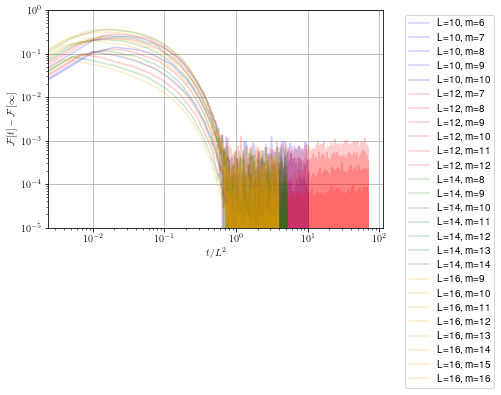

In [17]:
ns = [10,12,14,16]

colors = {
    n: c for n,c in zip(ns, ["b", "r", "g", "orange"])
}

for n in ns:
    filename = os.path.join(output_dir, f"dephased_uniform_l={n}.npz")

    arr = numpy.load(filename)
    all_purities = arr['data']
    D = arr['D']
    
    theory_purities = []
    for i in range(0,n+1):
        numerator = 4 * (n - i)**2 * i + 2 * (i - 1)*i + (n-i)**2 * (1-n+i)**2
        denom = (n - 1)**2 * n**2
        theory_purities.append(numerator/denom)
    theory_purities
    
    for i in range(len(all_purities)//2+1,len(all_purities)):
        purs = all_purities[i]
        pyplot.plot(numpy.arange(len(purs))/n**2, purs - theory_purities[i], c=colors[n], label=f'L={n}, m={i}', alpha=0.2)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.ylim([1e-5,1e0])
pyplot.ylabel('$\mathcal{F}[t] - \mathcal{F}[\infty]$')
pyplot.xlabel('$t/L^2$')
pyplot.legend(bbox_to_anchor=(1.05,1.0))
pyplot.grid()
pyplot.show()